<a href="https://colab.research.google.com/github/josmuniz/Brain_Image_Supervised-Unsupervised-Learning/blob/version2/COMP263_G5_Brain_Tumor_Generation_GAN_V1_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**El cambio principal fue usando keras instead of Tensorflow**

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import cv2
import os
from keras.models import Sequential
from keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, Dropout
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, Dropout

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# Initialize lists to store images and labels
X = []
Y = []
# Define directories for the two classes: "no" and "yes"
dirs = ['../content/drive/MyDrive/brain_tumor_dataset/to_train_validate/no','../content/drive/MyDrive/brain_tumor_dataset/to_train_validate/yes']
# Iterate over directories
for i in dirs:
    path = i
    # Iterate over images in each directory
    for x in os.listdir(path):
        # Read, resize, and convert images to grayscale
        img = cv2.imread(path + '/'+ x)
        img = cv2.resize(img,(128, 128), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(128,128,1)
        X.append(img)
        Y.append(i)
# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)
print("Shape of X: ", np.shape(X))
print("Shape of Y: ", np.shape(Y))

Shape of X:  (241, 128, 128, 1)
Shape of Y:  (241,)


In [54]:
# normalize images
X = (X.astype(np.float32) - 127.5)/127.5
# print("Shape of X: ", np.shape(X))
# print("Shape of X: ", X1)
# reshape images
X = X.reshape(X.shape[0], 128*128)
print("Shape of X: ", np.shape(X))


Shape of X:  (241, 16384)


In [55]:
#Building the generator model of the GAN
generator_model = Sequential([
    Dense(256, input_shape=(100,)),
    BatchNormalization(),
    LeakyReLU(0.2),
    Reshape((16, 16, 1)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])
# Print summary of the generator model
generator_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 batch_normalization_10 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 256)               0         
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 1)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 16, 16, 128)       3200      
 DTranspose)                                                     
                                                                 
 batch_normalization_11 (Ba  (None, 16, 16, 128)      

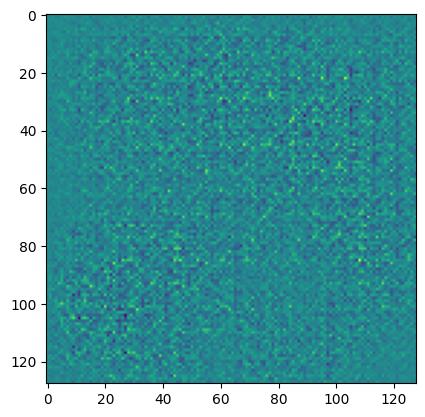

In [56]:
#sample untrained generator
sample_vector = tf.random.normal([1, 100])
sample_image = generator_model(sample_vector, training=False)
plt.imshow(sample_image[0, :, :, 0], cmap='viridis')

In [57]:
#Building the discriminator GAN
discriminator_model = Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(1)
])
# Print summary
discriminator_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        1664      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_14 (Conv2  (None, 64, 64, 64)       

In [58]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.legacy.Adam()
discriminator_optimizer = tf.keras.optimizers.legacy.Adam()

def training_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model(noise, training=True)
        real_output = discriminator_model(images, training=True)
        fake_output = discriminator_model(generated_images, training=True)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))
    return gen_loss, disc_loss

In [59]:
import time
from keras.preprocessing.image import ImageDataGenerator

epochs = 3000
batch_size = 32
gen_loss_history = []
disc_loss_history = []

# Define the image generator
datagen = ImageDataGenerator(
rotation_range=20, # Random rotation range (in degrees)
width_shift_range=0.1, # Random horizontal shift range
height_shift_range=0.1, # Random vertical shift range
shear_range=0.2, # Random shear range
zoom_range=0.2, # Random zoom range
horizontal_flip=True, # Random horizontal flip
fill_mode='nearest' # Fill strategy for pixels outside the original image boundaries
)

# Reshape the data
X = X.reshape(-1, 128, 128, 1)

# Iterator augmented images
augmented_images = datagen.flow(X, batch_size=batch_size)

print("Number of augmented_images: ", augmented_images.n)

Number of augmented_images:  241


In [60]:
# Training with augmented images
for epoch in range(epochs):
    start_time = time.time()
    for i in range(0, len(X), batch_size):
        batch_images = next(augmented_images)
        gen_loss, disc_loss = training_step(batch_images)
        gen_loss_history.append(gen_loss)
        disc_loss_history.append(disc_loss)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))

Time for epoch 1 is 2.734659433364868 sec
Time for epoch 2 is 1.671534538269043 sec
Time for epoch 3 is 1.6650450229644775 sec
Time for epoch 4 is 1.623702049255371 sec
Time for epoch 5 is 1.654557228088379 sec
Time for epoch 6 is 1.8042163848876953 sec
Time for epoch 7 is 2.188885450363159 sec
Time for epoch 8 is 1.7699964046478271 sec
Time for epoch 9 is 1.6348850727081299 sec
Time for epoch 10 is 1.6547694206237793 sec
Time for epoch 11 is 1.6262290477752686 sec
Time for epoch 12 is 1.6431376934051514 sec
Time for epoch 13 is 1.647883415222168 sec
Time for epoch 14 is 2.0082881450653076 sec
Time for epoch 15 is 2.0742580890655518 sec
Time for epoch 16 is 1.641273021697998 sec
Time for epoch 17 is 1.6072282791137695 sec
Time for epoch 18 is 1.6544673442840576 sec
Time for epoch 19 is 1.6714706420898438 sec
Time for epoch 20 is 1.6803159713745117 sec
Time for epoch 21 is 1.6900897026062012 sec
Time for epoch 22 is 2.1360106468200684 sec
Time for epoch 23 is 1.8471002578735352 sec
Time

In [61]:
# Generating 16 sample vectors
sample_vectors = tf.random.normal(shape=(16, 100))

# Generating images from the generator
generated_images = generator_model(sample_vectors, training=False)

# Normalizing the pixels in the generated images
generated_images = (generated_images * 127.5) + 127.5

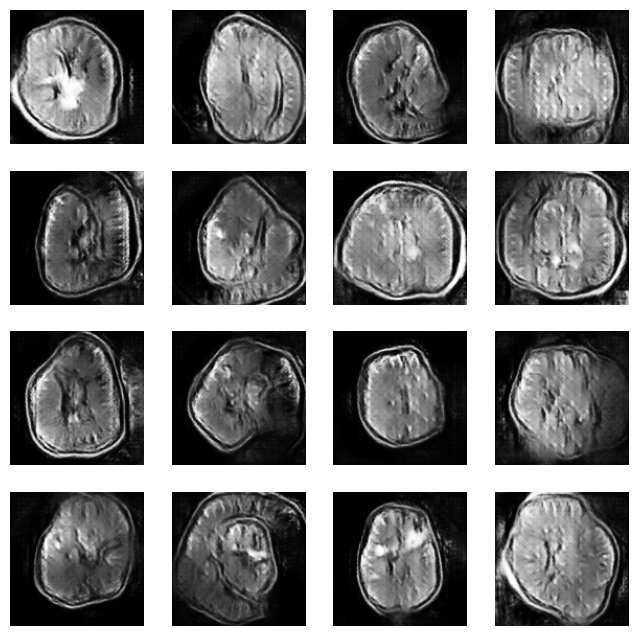

In [62]:
# Plotting the generated images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


In [63]:
# Generating 16 sample vectors
sample_vectors = tf.random.normal(shape=(16, 100))

# Generating images from the generator
generated_images = generator_model(sample_vectors, training=False)

# Normalizing the pixels in the generated images
generated_images = (generated_images * 127.5) + 127.5

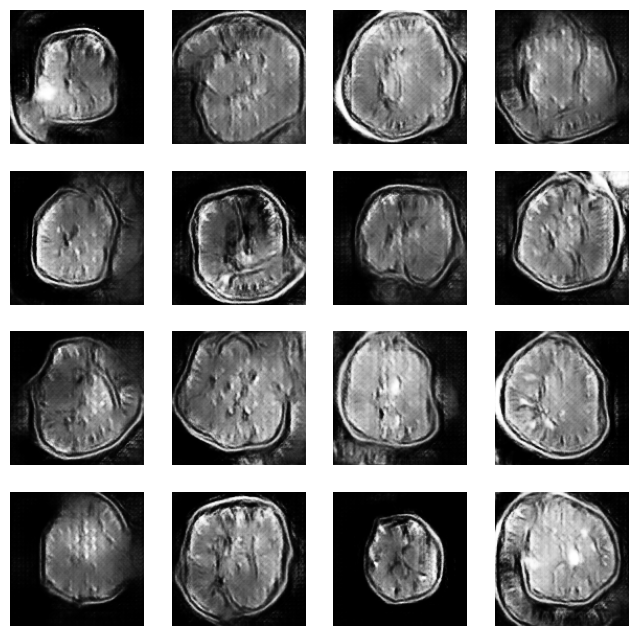

In [64]:
# Plotting the generated images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


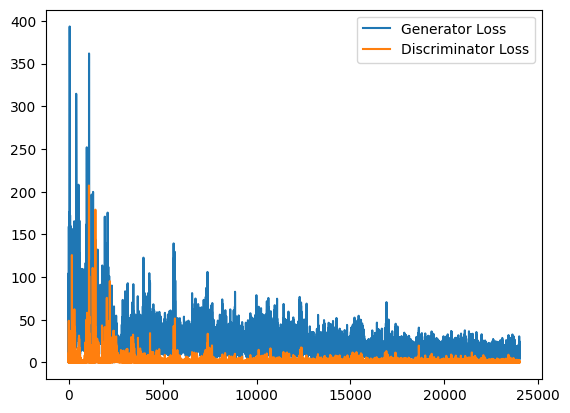

In [65]:
#plotting the loss history of the generator and discriminator
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(disc_loss_history, label='Discriminator Loss')
plt.legend()
plt.show()